In [4]:
import matplotlib.pyplot as plt
import numpy as np
import uproot

from lmfit.models import GaussianModel, ExponentialModel, \
                         StepModel, PowerLawModel #Modelli vari, l'ultimo è Fermi (o Bose)

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


# prove con Noise

In [450]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


<BarContainer object of 899 artists>

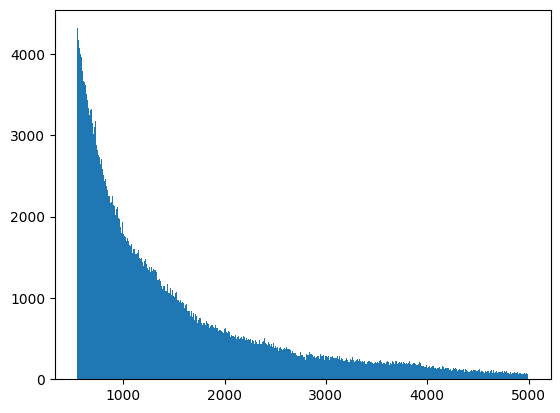

In [451]:
FILE_PATH="../../Dati/Run_X_50_5000_ChargeHistos_5_30_2024.dat"
edge_N, bin_N = load_histo(FILE_PATH)

channel=0

edge_N = edge_N[channel][00:900]
bin_N = bin_N[channel][00:900]

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)
plt.bar(-centers_N, bin_N[:-1], width=centers_N[1]-centers_N[0])


In [415]:
print(len(centers_N),len(bin_N),len(err_N),len(bin_N[:-1]))

899 900 900 899


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      4326     -inf      inf     None     True     None     None
e1_decay            -1     -inf      inf     None     True     None     None
s1_amplitude      4266     -inf      inf     None     True     None     None
s1_center        -2772     -inf        0     None     True     None     None
s1_sigma           635        0      inf     None     True     None     None
[[Model]]
    (Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3848
    # data points      = 899
    # variables        = 5
    chi-square         = 31753.0739
    reduced chi-square = 35.5179798
    Akaike info crit   = 3214.45114
    Bayesian info crit = 3238.45756
    R-squared          = 0.99995133
##  Warning: uncertainties could not be estimated:
    e1_amplitude:  at initial value
    e1_decay:      at initial value
[

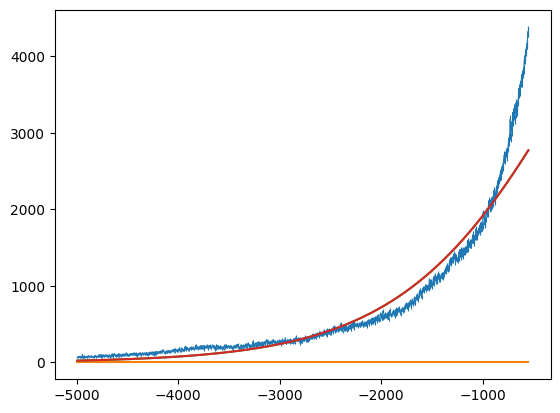

In [429]:
exp1   = ExponentialModel(prefix='e1_')
sigmoid1 = StepModel(form = "logistic", prefix='s1_')
exp2   = ExponentialModel(prefix='e2_')
pow1   = PowerLawModel(prefix='p1_')
params = exp1.guess(bin_N, x=centers_N) 
params.update(sigmoid1.guess(bin_N, x=centers_N))


params["s1_center"].set(max=0)
#params["p1exponent"].set(max=0, min=-10)
model = exp1+sigmoid1

params.pretty_print()
comps = result.eval_components()  
result = model.fit(bin_N[:-1], params, x = centers_N, weights = 1 / err_N[:-1], method = "leastsq")
plt.errorbar(centers_N, bin_N[:-1], yerr=err_N[:-1], linewidth = 0.8, markersize = 0.5)
plt.plot(centers_N, comps['e1_'])
plt.plot(centers_N, comps['s1_'])
#plt.bar(centers_N, bin_N[:-1], color='r',width=centers_N[1]-centers_N[0])
plt.plot(centers_N, result.best_fit, label='Best Fit', zorder = 10)

print(result.fit_report())

# Fit solo picco

In [63]:
FILE_PATH="../../Dati/Run_Cs_batches_bis_Measurements_Only_5_29_2024_0000.root"
file = uproot.open(FILE_PATH)
file["tree"].show()

charges = np.array(file["tree"]["charge"].array()[1:-1])
channels= np.array(file["tree"]["ch"].array()[1:-1])
print(charges.shape)

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
(499998, 15)


In [573]:
print(channels.shape)

(499998, 15)


14
[-690, -580]


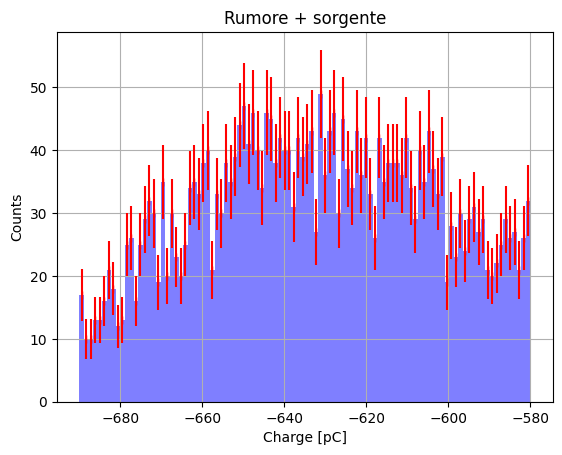

In [75]:
channel=0
Nbin = 100

channel_idx = [0,  1, 2, 3, 4, 5, 6, 7,  8, 9,  10, 11, 12, -1, 13,14]

lim_list = [[-690, -580],  #ch0
            [-650, -520],      #ch1
            [-2550, -2100],  #ch2
            [-1550, -1250],  #ch3
            [-1050, -850],  #ch4
            [-1770, -1470],  #ch5
            [-1200, -970],  #ch6
            [-1700, -1500],  #ch7
            [-1400, -1100],  #ch8
            [-800, -600],  #ch9
            [-600, -500],  #ch10
            [-940, -780],  #ch11
            [-940, -750],      #ch12
            [-1,-1], #ch13
            [-1600, -1300],      #ch14
            [-2200, -1850],  #ch15
            
            ]
print(channel_idx[15])

bin_lims = lim_N= lim_list[channel]#Scelgo gli estremi
print(bin_lims)
_, edges, _ = plt.hist(charges[:,channel_idx[channel]], bins = Nbin, color = "r")
plt.clf()
binCs, edgesCs, _ = plt.hist(charges[:,channel_idx[channel]], bins = Nbin, range=lim_list[channel], color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 100
    # variables        = 3
    chi-square         = 111.582794
    reduced chi-square = 1.15033809
    Akaike info crit   = 16.9596680
    Bayesian info crit = 24.7751786
    R-squared          = 0.98761699
[[Variables]]
    g3_amplitude:  4070.53735 +/- 118.041560 (2.90%) (init = 5405.401)
    g3_center:    -629.373779 +/- 1.21396359 (0.19%) (init = -632.9283)
    g3_sigma:      40.5819560 +/- 1.61367757 (3.98%) (init = 46.20001)
    g3_fwhm:       95.5632002 +/- 3.79992021 (3.98%) == '2.3548200*g3_sigma'
    g3_height:     40.0155566 +/- 1.07400364 (2.68%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.7379
    C(g3_center, g3_sigma)     = +0.3283
    C(g3_amplitude, g3_center) = +0.3091


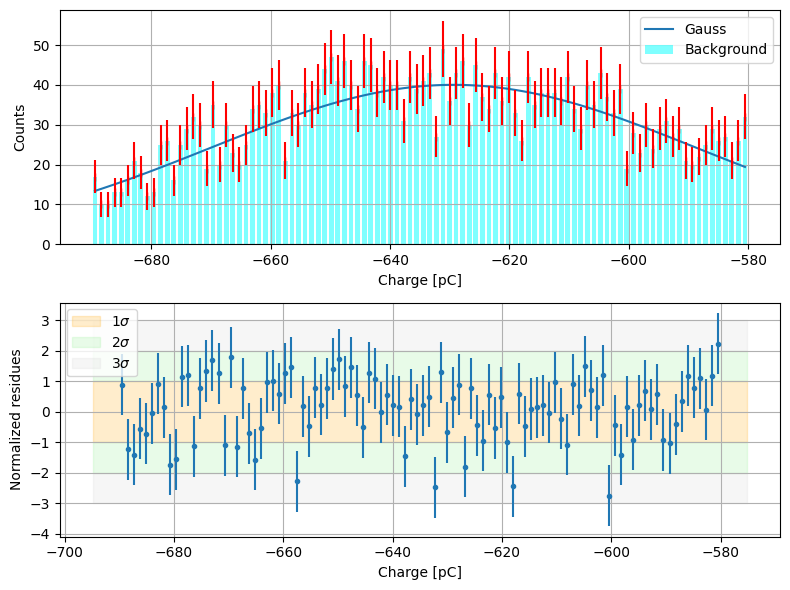

In [76]:
gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(binCs, x = centersCs)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(binCs, params2, x = centersCs, weights = 1 / errCs, nan_policy='omit')

print(result2.fit_report())




gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(binCs, x = centersCs)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(binCs, params2, x = centersCs, weights = 1 / errCs, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar( centersCs, binCs, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
ax1.grid()

residueGauss = binCs - result2.best_fit
norm_res_gauss = residueGauss / errCs

ax2.errorbar(centersCs, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()




# Fit Solo Picco 2

In [77]:
FILE_PATH="../../Dati/Run_Cs_batches_Measurements_Only_5_29_2024_0001.root"
file = uproot.open(FILE_PATH)
file["tree"].show()

charges = np.array(file["tree"]["charge"].array()[1:-1])
channels= np.array(file["tree"]["ch"].array()[1:-1])
print(charges.shape)

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
(495535, 15)


In [6]:
print(channels.shape)

(495535, 15)


14
[-700, -580]


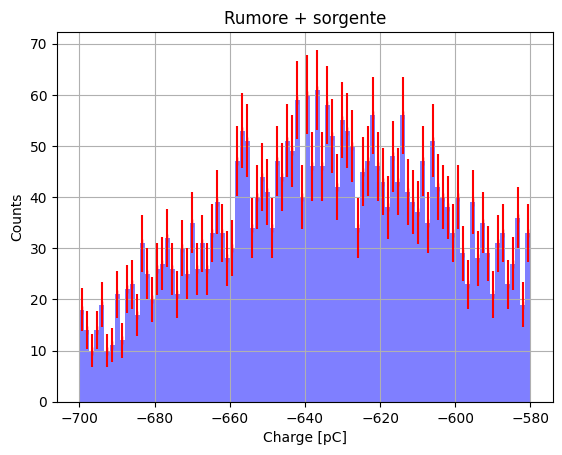

In [79]:
channel=0
Nbin = 90

channel_idx = [0,  1, 2, 3, 4, 5, 6, 7,  8, 9,  10, 11, 12, -1, 13,14]

lim_list = [[-700, -580],  #ch0
            [-660, -530],      #ch1
            [-2550, -2100],  #ch2
            [-1550, -1270],  #ch3
            [-1050, -850],  #ch4
            [-1770, -1450],  #ch5
            [-1150, -970],  #ch6
            [-1700, -1500],  #ch7
            [-1400, -1100],  #ch8
            [-800, -600],  #ch9
            [-600, -500],  #ch10
            [-940, -780],  #ch11
            [-940, -750],      #ch12
            [-1,-1], #ch13
            [-1600, -1300],      #ch14
            [-2200, -1850],  #ch15
            
            ]
print(channel_idx[15])

bin_lims = lim_N= lim_list[channel]#Scelgo gli estremi
print(bin_lims)
_, edges, _ = plt.hist(charges[:,channel_idx[channel]], bins = Nbin, color = "r")
plt.clf()
binCs, edgesCs, _ = plt.hist(charges[:,channel_idx[channel]], bins = Nbin, range=lim_list[channel], color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 90
    # variables        = 3
    chi-square         = 98.0272160
    reduced chi-square = 1.12674961
    Akaike info crit   = 13.6891936
    Bayesian info crit = 21.1886226
    R-squared          = 0.99317191
[[Variables]]
    g3_amplitude:  4840.68110 +/- 122.064497 (2.52%) (init = 6120)
    g3_center:    -630.726443 +/- 1.13326983 (0.18%) (init = -627.7985)
    g3_sigma:      40.2526004 +/- 1.35573242 (3.37%) (init = 40)
    g3_fwhm:       94.7876270 +/- 3.19250583 (3.37%) == '2.3548200*g3_sigma'
    g3_height:     47.9758441 +/- 1.24552459 (2.60%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.6454
    C(g3_center, g3_sigma)     = +0.3875
    C(g3_amplitude, g3_center) = +0.3497


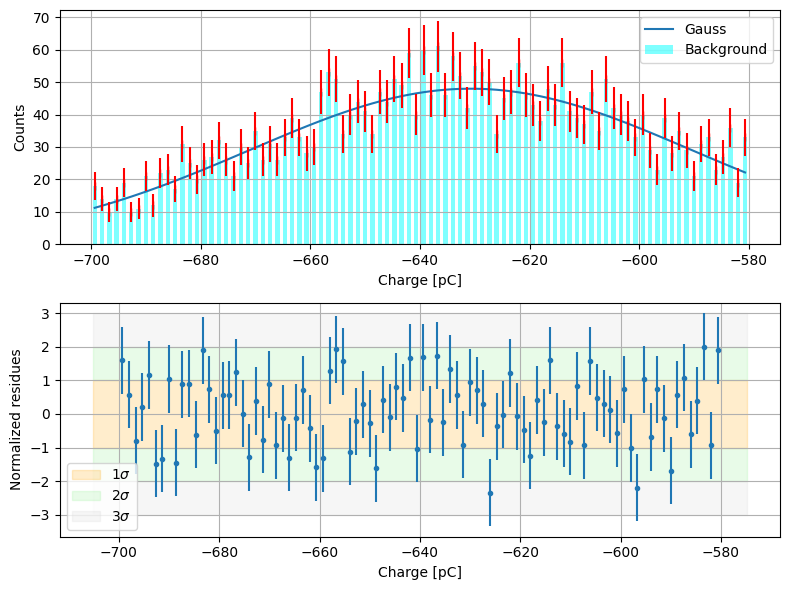

In [80]:
gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(binCs, x = centersCs)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(binCs, params2, x = centersCs, weights = 1 / errCs, nan_policy='omit')

print(result2.fit_report())




gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(binCs, x = centersCs)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(binCs, params2, x = centersCs, weights = 1 / errCs, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar( centersCs, binCs, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
ax1.grid()

residueGauss = binCs - result2.best_fit
norm_res_gauss = residueGauss / errCs

ax2.errorbar(centersCs, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()




# altra spazzatura

In [2]:
err_N = errCs[np.where((centersCs > bin_lims[0]) & (centersCs < bin_lims[1]))]
bin_N = binCs[np.where((centersCs > bin_lims[0]) & (centersCs < bin_lims[1]))]
centers_N = centersCs[np.where((centersCs > bin_lims[0]) & (centersCs < bin_lims[1]))]

NameError: name 'errCs' is not defined

In [ ]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide


params = exp1.guess(binCs, x=centersCs)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(binCs, x=centersCs))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))


model = exp1 + gauss1 + sigmoid1 + sigmoid2  

In [ ]:
#CARICHIAMO I VALORI DI PARTENZA SU RUMORE
import pickle
with open("../../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)
noise_params[0].pretty_print()
#print(noise_params[0])

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      6003     -inf      inf    80.95     True     None     None
e1_decay        -98.31     -inf      inf   0.5787     True     None     None
ratio            30.15     -inf      inf   0.9219    False e1_amplitude / s1_amplitude     None
s1_amplitude     199.1        0      inf    5.029     True     None     None
s1_center         -423     -inf      inf    1.504     True     None     None
s1_sigma         25.49        0      inf      1.1     True     None     None


In [ ]:
#IMPOSTIAMO I PARAMETRI
params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0

params["s1_amplitude"].value = noise_params[0]["s1_amplitude"].value
params["s1_center"].value = noise_params[0]["s1_center"].value
params["s1_sigma"].value = noise_params[0]["s1_sigma"].value
params["e1_decay"].value = noise_params[0]["e1_decay"].value
#params.add("ratio", value = noise_params["ratio"].value)
params["e1_amplitude"].set(vary=True, expr = "")



# Fit the model to the data
if channel ==0:
    params["g1_amplitude"].set(value = 11348, min=0 )   
    params["g1_center"].set(value = -650)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 40, min=0, max = 140)
    params["s2_center"].set(value = -450 , max=-500)
    params["s2_sigma"].set(value = 25, min=0)

    params["e1_amplitude"].set(min=0)
    params["e1_decay"].set(value=-101)

if channel ==1:
    params["g1_amplitude"].set(value = 15348, min=8000 )   
    params["g1_center"].set(value = -600)        
    params["g1_sigma"].set(value = 18)

    params["s2_amplitude"].set(value = 100, min=0)
    params["s2_center"].set(value = -420 )
    params["s2_sigma"].set(value = 5, min = 0)

    params["e1_amplitude"].set(value = 101, min=0)
    params["e1_decay"].set(value=-81)

    params["s1_amplitude"].set(value= 21, min = 10, max = 80)
    params["s1_center"].set(value=-320)
    params["s1_sigma"].set( value= 15, min = 0)



if channel ==2:
    params["g1_amplitude"].set(value = 15348, min=8000 )   
    params["g1_center"].set(value = -2300)        
    params["g1_sigma"].set(value = 18)

    params["s2_amplitude"].set(value = 100, min=0)
    params["s2_center"].set(value = -1500 )
    params["s2_sigma"].set(value = 5, min = 0)

    params["e1_amplitude"].set(value = 101, min=0)
    params["e1_decay"].set(value=-81)

    params["s1_amplitude"].set(value= 21, min = 10, max = 80)
    params["s1_center"].set(value=-320)
    params["s1_sigma"].set( value= 15, min = 0)

if channel ==3:
    params["g1_amplitude"].set(value = 25348, min=10000 )   
    params["g1_center"].set(value = -1400)        
    params["g1_sigma"].set(value = 55)

    params["s2_amplitude"].set(value = 50)
    params["s2_center"].set(value = -810 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 50)
    params["s1_center"].set(value=-900)
    params["s1_sigma"].set( value= 40, min = 0)

if channel == 4:
    
    params["g1_amplitude"].set(value = 25348, min=0 )   
    params["g1_center"].set(value = -900, min = -1650 , max = -140)        
    params["g1_sigma"].set(value = 55)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -600, min=-800,max=-450 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-1150)
    params["s1_sigma"].set( value= 30, min = 0)
  
if channel == 5:
    params["g1_amplitude"].set(value = 22348, min=0 )   
    params["g1_center"].set(value = -1600)        
    params["g1_sigma"].set(value = 66)

    params["s2_amplitude"].set(value = 500, min=0)
    params["s2_center"].set(value = -600)
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-1150)
    params["s1_sigma"].set( value= 30, min = 0)

if channel ==6:
    params["g1_amplitude"].set(value = 11348, min=0 )   
    params["g1_center"].set(value = -1100)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 40)
    params["s2_center"].set(value = -700 )
    params["s2_sigma"].set(value = 8, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-101)

    params["s1_amplitude"].set(value= 60)
    params["s1_center"].set(value=-650)
    params["s1_sigma"].set( value= 40, min = 0)

if channel ==7:
    params["g1_amplitude"].set(value = 22348, min=0 )   
    params["g1_center"].set(value = -1600)        
    params["g1_sigma"].set(value = 66)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -800 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-600)
    params["s1_sigma"].set( value= 30, min = 0)

if channel == 8:
    params["g1_amplitude"].set(value = 22348, min=0 )   
    params["g1_center"].set(value = -1100, min = -1200 , max = -1000)        
    params["g1_sigma"].set(value = 50)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -600, min=-800,max=-450 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 1070, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 60, min = 20)
    params["s1_center"].set(value=-1150)
    params["s1_sigma"].set( value= 30, min = 0)

if channel == 10:

    params["g1_amplitude"].set(value = 13348, min=0 )   
    params["g1_center"].set(value = -389, min = -450 , max = -350)        
    params["g1_sigma"].set(value = 19)

    params["s2_amplitude"].set(value = 70, min=0, max = 140)
    params["s2_center"].set(value = -270, min=-300,max=-220 )
    params["s2_sigma"].set(value = 10, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-100)

    params["s1_amplitude"].set(value= 40, min = 10, max = 190)
    params["s1_center"].set(value=-350, min = -650, max = -300)
    params["s1_sigma"].set( value= 15, min = 0)

if channel == 11:

    params["g1_amplitude"].set(value = 13348, min=0 )   
    params["g1_center"].set(value = -559, min = -600 , max = -500)        
    params["g1_sigma"].set(value = 19)

    params["s2_amplitude"].set(value = 70, min=0, max = 140)
    params["s2_center"].set(value = -350, min=-400,max=-220 )
    params["s2_sigma"].set(value = 10, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-100)

    params["s1_amplitude"].set(value= 40, min = 10, max = 190)
    params["s1_center"].set(value=-350, min = -650, max = -300)
    params["s1_sigma"].set( value= 15, min = 0)

if channel == 14:

    params["g1_amplitude"].set(value = 13348, min=0 )   
    params["g1_center"].set(value = -559, min = -600 , max = -500)        
    params["g1_sigma"].set(value = 19)

    params["s2_amplitude"].set(value = 70, min=0, max = 140)
    params["s2_center"].set(value = -350, min=-400,max=-220 )
    params["s2_sigma"].set(value = 10, min = 0)

    params["e1_amplitude"].set(value = 800, min=0)
    params["e1_decay"].set(value=-100)

    params["s1_amplitude"].set(value= 40, min = 10, max = 190)
    params["s1_center"].set(value=-350, min = -650, max = -300)
    params["s1_sigma"].set( value= 15, min = 0)

if channel == 15:
    params["g1_amplitude"].set(value = 25348, min=0 )   
    params["g1_center"].set(value = -800, min = -900 , max = -700)        
    params["g1_sigma"].set(value = 50)

    params["s2_amplitude"].set(value = 500, min=0, max = 140)
    params["s2_center"].set(value = -500, min=-700,max=-400 )
    params["s2_sigma"].set(value = 30, min = 0)

    params["e1_amplitude"].set(value = 600, min=0)
    params["e1_decay"].set(value=-250)

    params["s1_amplitude"].set(value= 40, min = 20)
    params["s1_center"].set(value=-800)
    params["s1_sigma"].set( value= 40, min = 0)


params.update(params)
params.pretty_print()


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      1070        0      inf     None     True     None     None
e1_decay          -250     -inf      inf     None     True     None     None
g1_amplitude  2.235e+04        0      inf     None     True     None     None
g1_center        -1600     -inf      inf     None     True     None     None
g1_fwhm          155.4     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height        135.1     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            66        0      inf     None     True     None     None
s1_amplitude        60       20      inf     None     True     None     None
s1_center         -600     -inf      inf     None     True     None     None
s1_sigma            30        0      inf     None     True     None     None
s2_amplitude       140        0      140     None     True     None     None
s2_center         -800     -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


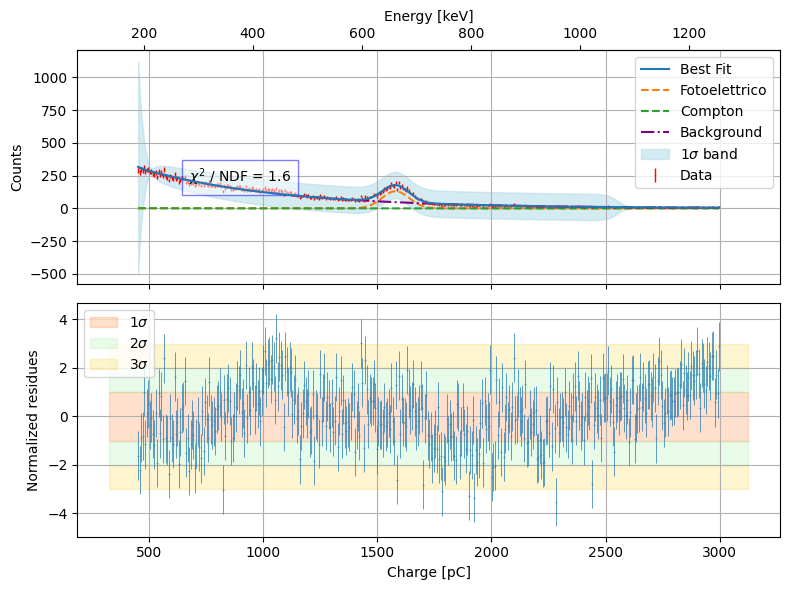

In [ ]:
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N, method = "leastsq")

def pCtoKev(x):
    return -x / result.params["g1_center"].value * 661.7

def KevtopC(x):
    return -x * result.params["g1_center"].value / 661.7



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex = True)


#ax1.bar(centers_N, bin_N, alpha = 0.5, width = 0.7)
#ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(-centers_N[::-1], result.best_fit[::-1], label='Best Fit', zorder = 10)
ax1.plot(-centers_N[::-1], comps['g1_'][::-1], label='Fotoelettrico', ls = "--")
ax1.plot(-centers_N[::-1], comps['s2_'][::-1], label='Compton', ls = "--")

ax1.plot(-centers_N[::-1], comps['e1_'][::-1] + comps['s1_'][::-1], label='Background', ls = "-.",
         color = "purple")
         #color = "#17BEBB")
#ax1.plot(-centers_N[::-1], comps['e1_'][::-1], label='Background Exp', ls = "-.")
#ax1.plot(-centers_N[::-1], comps['s1_'][::-1], label='Background FD', ls = "-.")

ax1.errorbar(-centers_N[::-1], bin_N[::-1], err_N[::-1], color = "red", fmt='|', linewidth = 1, 
             markersize = 0.5, label = "Data")


dely = result.eval_uncertainty(sigma=1)
ax1.fill_between(-centers_N[::-1],
                        (result.best_fit-dely)[::-1],
                        (result.best_fit+dely)[::-1],
                        color="lightblue", alpha = 0.5, label = r'$1\sigma$ band')

ax1.text(-np.max(lim_N) * 2, bin_N.max(), r'$\chi^2$ / NDF = ' + str(round(result.redchi, 1)), 
         fontsize=10, color='black', ha = "center", va = "top", 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='square,pad=0.5'))

ax1.grid()
ax1.legend(loc = 1)


residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(-centers_N[::-1], norm_resCs[::-1], 1, ls = "", marker = ".", linewidth = 0.5, markersize = 0.5)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "#FF6700", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "#F7CB15", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "#F7CB15", alpha = 0.2)

ax2.legend()

secax = ax1.secondary_xaxis('top', functions=(pCtoKev, KevtopC))
secax.set_xlabel('Energy [keV]')
'''
ax3 = ax2.twinx()
ax3.set_xticks(pCtoKev(np.array(ax1.get_xticks())))
ax3.set_xlabel("Energy [keV]")
ax3.set_xticklabels(np.round(pCtoKev( np.array(ax1.get_xticks())) ))
ax3.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax3.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax3.spines['bottom'].set_position(('outward', 36))

ax3.set_xlim(np.array(ax1.get_xlim()) * -result.params["g1_center"].value / 661.7)


ax3.plot()
'''
fig.tight_layout()

plt.show()

In [ ]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 400
    # variables        = 11
    chi-square         = 611.193094
    reduced chi-square = 1.57119047
    Akaike info crit   = 191.579357
    Bayesian info crit = 235.485467
    R-squared          = 0.99975953
[[Variables]]
    e1_amplitude:  654.944806 +/- 30.8703948 (4.71%) (init = 1070)
    e1_decay:     -600.525911 +/- 10.3499508 (1.72%) (init = -250)
    s1_amplitude:  67.0064484 +/- 16201.8089 (24179.48%) (init = 60)
    s1_center:    -408.078565 +/- 6425.62222 (1574.60%) (init = -600)
    s1_sigma:      21.1074674 +/- 367.875997 (1742.87%) (init = 30)
    g1_amplitude:  19507.8189 +/- 634.039047 (3.25%) (init = 22348)
    g1_center:    -1580.26606 +/- 2.09105118 (0.13%) (init = -1600)
    g1_sigma:   

## Sistematiche

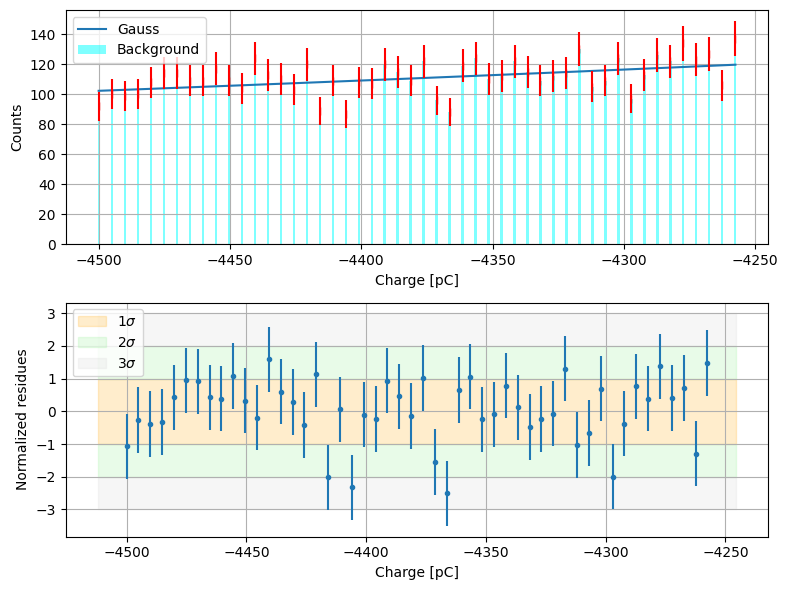

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8000
    # data points      = 50
    # variables        = 3
    chi-square         = 47.2766288
    reduced chi-square = 1.00588572
    Akaike info crit   = 3.19965313
    Bayesian info crit = 8.93572215
    R-squared          = 0.99256949
##  Warning: uncertainties could not be estimated:
[[Variables]]
    g3_amplitude:  4.2922e+11 (init = 16335)
    g3_center:     33341.6979 (init = -4353.272)
    g3_sigma:      7629.98579 (init = 108.9)
    g3_fwhm:       17967.2431 == '2.3548200*g3_sigma'
    g3_height:     22441991.8 == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'


In [ ]:
sist_lim_list = [[100, 150],  #ch0
                [120, 150],  #ch1
                [100,180],  #ch2
                [78,110],  #ch3
                [117,140],  #ch4
                [70,100],  #ch5
                [190,230],  #ch6
                [110, 200],  #ch7
                [380, 500],  #ch8
                [340, 470],  #ch9
                [190, 270],  #ch10
                [380, 480],  #ch11
                [-1, -1],  #ch12
                [-1, -1],  #ch13
                [380, 495],  #ch14
                [155, 250]   #ch15
                ]


sist_lims = sist_lim_list[channel]
sist_bin = bin_N[sist_lims[0]:sist_lims[1]]
sist_cntr = centers_N[sist_lims[0]:sist_lims[1]]
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

In [ ]:
print(f'La sistematica è {result.params["g1_center"].value - result2.params["g3_center"].value}')

La sistematica è -2.9262453408191504
